In [3]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

print_config()

MONAI version: 1.3.0
Numpy version: 1.26.3
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: c:\Users\DC\Desktop\Monai\.ven\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.13.0
Pillow version: 10.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.7.3
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.4
lmdb version: 1.4.1
psutil version: 5.9.8
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.21.3
mlflow version: 2.12.2
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai

In [4]:
torch.cuda.is_available()

True

In [18]:
 pip install wget  # Install wget 

Note: you may need to restart the kernel to use updated packages.


In [17]:
!python -m wget https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz


Saved under MedNIST.tar.gz


In [23]:
# unzip the '.tar.gz' file to the current directory
import tarfile
datafile = tarfile.open("MedNIST.tar.gz")
datafile.extractall()
datafile.close()


### Read image filenames from the dataset folders

First of all, check the dataset files and show some statistics. There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT, which should be used as the labels to train our classification model.


In [5]:
data_dir = './MedNIST'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x)
                for x in os.listdir(os.path.join(data_dir, class_name))]
               for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i]*len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[i]).size

print('Total Image Count:', num_total)
print('Image Dimensions:', image_width, "x", image_height)
print("Label Names:", class_names)
print("Label Counts:", [len(image_files[i]) for i in range(num_class)])




Total Image Count: 58954
Image Dimensions: 64 x 64
Label Names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label Counts: [10000, 8954, 10000, 10000, 10000, 10000]


### Visualize some randomly picked examples from the dataset

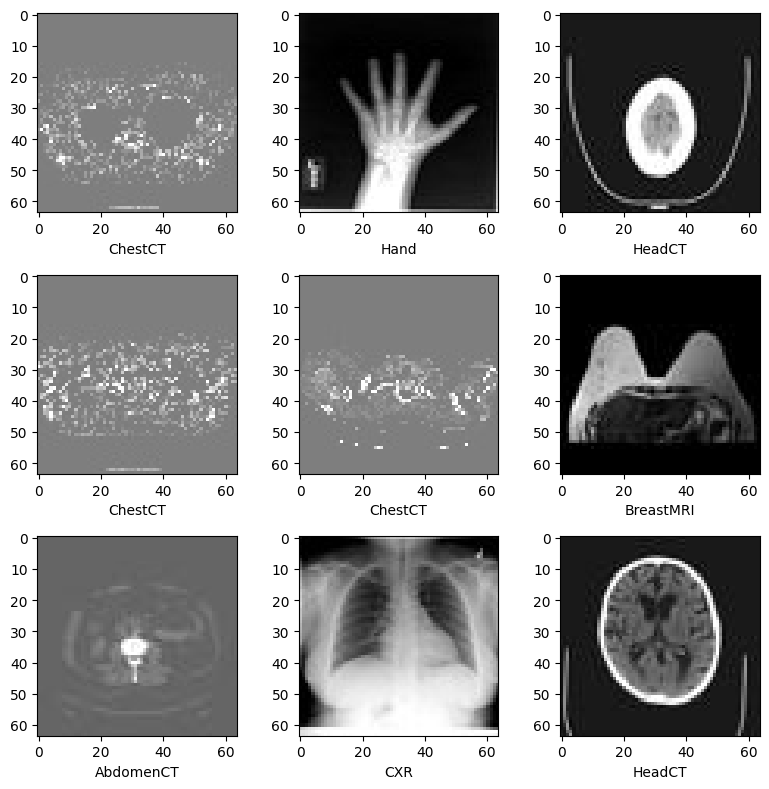

In [4]:
plt.subplots(3, 3, figsize=(8,8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    
    
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i+1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()


### Prepare Training, Validation, and Test Data Lits

Randomly select 10% of the dataset as a validation and 10% as a test dataset

In [6]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_file_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_file_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_file_list[i])
        
print("Training Count =",len(trainX), "Validation Count =", len(valX), "Testing Count =:", len(testX))

Training Count = 47255 Validation Count = 5832 Testing Count =: 5867


### Define MONAI transforms, Dataset and DataLoader to pre-process the data

In [7]:
train_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()  
])

Val_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    ToTensor 
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class)

In [8]:
class MedNISTDataset(Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]
    
train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle = True, num_workers=2)
    
val_ds  = MedNISTDataset(valX, valY, Val_transforms)
val_loader = DataLoader(val_ds, batch_size = 300, num_workers=2)

test_ds = MedNISTDataset(testX, testY, Val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=2)

### Define Network and Optimizer

1. Set learning rate for how much the model is updated per batch.

2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different. And as this is just a get start tutorial, let's just train 4 epochs. If train 10 epochs, the model can achieve 100% accuracy on test dataset.

3. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.

4. Use Adam optimizer.

In [9]:
device = torch.device("cuda:0")
model = DenseNet121(
    spatial_dims = 2,
    in_channels =1,
    out_channels = num_class
).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num  = 4
val_interval = 1

### Model Training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch. Will save the model weights to file if got best validation accuracy.

In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()

for epoch in range(epoch_num):
    print('_' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
        
        
    
    
    

__________
epoch 1/4


### Plot the loss and metric

In [ ]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

After training and validation, we already got the best model on validation test. We need to evaluate the model on test dataset to check whether it's robust and not over-fitting. We'll use these predictions to generate a classification report.

In [10]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))